In [1]:
from IPython.display import display
from pprint import pformat, pprint

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))
rcParams["axes.formatter.limits"] = (-2, 2)

from scipy.sparse import *
from scipy.sparse.linalg import spsolve

In [2]:
def exact1(x, t, k):
    return 2*k**2/cosh(k*(x - 4*k**2*t))**2

def exact2(x, t, k1, k2):
    assert k1 > k2
    xi1, xi2 = k1*(x - 4*k1**2*t), k2*(x - 4*k2**2*t)
    return 8*(k1**2 - k2**2)*(k1**2*cosh(xi2)**2 + k2**2*sinh(xi1)**2)/\
        ((k1 - k2)*cosh(xi1 + xi2) + (k1 + k2)*cosh(xi1 - xi2))**2

In [3]:
fnt = 10
deg_h = 2
def draw1(sol, exact, loc, name=""):
    figure(figsize=(7, 15))
    
    splt1 = subplot(5, 1, 1)
    ylabel(r'$u(t, x)$', {'fontsize': fnt})
#     xlabel(r'$x$', {'fontsize': fnt})
    setp(splt1.get_xticklabels(), visible=True)
    grid(True)

    splt2 = subplot(5, 1, 2)
    ylabel(r'$h^%d$' % deg_h, {'fontsize': fnt})
#     xlabel(r'$x$', {'fontsize': fnt})
    grid(True)
    
    splt3 = subplot(5, 1, 3)
    ylabel(r'$\tau^2$', {'fontsize': fnt})
#     xlabel(r'$x$', {'fontsize': fnt})
    grid(True)

    splt4 = subplot(5, 1, 4)
    ylabel(r'$FDA$', {'fontsize': fnt})
#     xlabel(r'$x$', {'fontsize': fnt})
    grid(True)
    
    splt5 = subplot(5, 1, 5)
    t, u, h2, tau2, fda = sol[-1]
    title(r"$e$=%.2e" % (norm(u - exact(x, t), inf)/(1 + norm(exact(x, t), inf))))
    ylabel(r'$error$', {'fontsize': fnt})
    xlabel(r'$x$', {'fontsize': fnt})
    grid(True)
    
    for t, u, h2, tau2, fda in sol: 
        splt1.plot(x, u, label="$t=%.2f$" % t)
        splt2.plot(x, h2, label="$t=%.2f$" % t)
        splt3.plot(x, tau2, label="$t=%.2f$" % t)
        splt4.plot(x, fda, label="$t=%.2f$" % t)
        splt5.plot(x, u - exact(x, t), label="$t=%.2f$" % t)
        print("    u = %.4f[%.4f]" % (max(u), x[argmax(u)]))
        print("exact = %.4f[%.4f]" % (max(exact(x, t)), x[argmax(exact(x, t))]))

    splt1.legend(loc=loc, fancybox=True)
    splt2.legend(loc=loc, fancybox=True)
    splt3.legend(loc=loc, fancybox=True)
    splt4.legend(loc=loc, fancybox=True)
    splt5.legend(loc=loc, fancybox=True)
    
    subplots_adjust(hspace=0.3, wspace=0.0)

    if name: savefig(name, pad_inches=0.0, dpi=300)
    else: show()
    close()

\begin{equation}
\begin{aligned}
  v^2_{k+1} &= v^2_{k+1} - v^2_{k} + v^2_{k} = (v_{k+1} - v_{k})(v_{k+1} + v_{k}) + v^2_{k}
\approx v_{k+1}\cdot 2v_{k} - v_{k}^2 , \\
v^3_{k+1} &= v^3_{k+1} - v^3_{k} + v^3_{k} = (v_{k+1} - v_{k})(v_{k+1}^2 +v_{k+1}v_{k} + v_{k}^2) + v^3_{k}
\approx v_{k+1}\cdot 3v_{k}^2 - 2v_{k}^3 .
\end{aligned}
\end{equation}

В результате получим следующую разностную схему для уравнения~(1.18), 
аналогичную схеме Кранка--Николсона для уравнения теплопроводности
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 +3\frac{\left({u^2}_{j+1}^{n+1} - {u^2}_{j-1}^{n+1}\right) +
              \left({u^2}_{j+1}^{n} - {u^2}_{j-1}^{n}\right)}{4h} + \\
 +\frac{\left({u}_{j+2}^{n+1} -2{u}_{j+1}^{n+1} +2{u}_{j-1}^{n+1} -{u}_{j-2}^{n+1}\right) +
             \left({u}_{j+2}^{n} -2{u}_{j}^{n+1} +2{u}_{j-1}^{n} -{u}_{j-2}^{n}\right)}{4h^{3}}=0.
\end{multline*}

In [4]:
def solve5(u0, dt, dx, t1, n):
    """
    u0 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    N = len(u0)
    assert 25 <= N
    
    # вспомогательные массивы для задания разреженной матрицы
    row = empty((N, 5), dtype=int32)
    col = zeros((N, 5), dtype=int32)
    data = zeros((N, 5), dtype=float64)

    # столбец свободных членов
    b = zeros(N, dtype=float64)

    # за нормировку строк матрицы взято dt/dx = O(1)
    for i in range(N):
        row[i] = i
    for i in range(2, N-2):
        col[i] = i-2, i-1, i, i+1, i+2

    # граничные условия в точке x[0]
#     col[0, :1] = 0
#     data[0, :1] = 1.
    col[0, :3] = 0, 1, 2
    data[0, :3] = -3/2, 4/2, -1/2
    # граничные условия в точке x[-1]
    col[-1, :3] = N-1, N-2, N-3
    data[-1, :3] = -3/2, 4/2, -1/2

    # задание неизменных элементов матрицы
    # (ответственны за линейные члены)
    
    col[1, :] = 0, 1, 2, 3, 4
    data[1, 1] = 10*dt/(4*dx**3)
    data[1, 3] =  6*dt/(4*dx**3)
    data[1, 4] =   -dt/(4*dx**3)
    
    data[2:-2, 0] = -dt/(4*dx**3)
    data[2:-2, 2] = 1.
    data[2:-2, 4] =  dt/(4*dx**3)

    col[-2, :] = N-5, N-4, N-3, N-2, N-1
    data[-2, 0] =     dt/(4*dx**3)
    data[-2, 1] =  -6*dt/(4*dx**3)
    data[-2, 3] = -10*dt/(4*dx**3)
    
    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol, k = u0, [(0, u0, zeros_like(u0),\
                      zeros_like(u0), zeros_like(u0))], int(t1/dt)//n
    assert k > 6
    for i in range(1, int(t1/dt)+7):
        # начало простой итерации для построения v решения для следующего временного слоя
        v, f, j = copy(u), True, 0
        while f:
            # задание переменных элементов матрицы
            # (ответственны за нелинейные члены)
            data[1, 0] = dt/dx*(-(f1 + 2*f2*v[0] + 3*f3*v[0]**2)/4\
                         - 3/(4*dx**2))
            data[1, 2] = dt/dx*( (f1 + 2*f2*v[2] + 3*f3*v[2]**2)/4\
                         - 12/(4*dx**2))
            
            data[2:-2, 1] = dt/dx*(-(f1 + 2*f2*v[1:-3] + 3*f3*v[1:-3]**2)/4\
                         + 2/(4*dx**2))
            data[2:-2, 3] = dt/dx*( (f1 + 2*f2*v[3:-1] + 3*f3*v[3:-1]**2)/4\
                         - 2/(4*dx**2))
            
            data[-2, 2] = dt/dx*(-(f1 + 2*f2*v[-3] + 3*f3*v[-3]**2)/4\
                         + 12/(4*dx**2))
            data[-2, 4] = dt/dx*( -(f1 + 2*f2*v[-1] + 3*f3*v[-1]**2)/4\
                         - 1/(4*dx**2))
            
            # вычисление правой части
            b[1] = u[1] + dt/dx*(\
                - f1*(u[2] - u[0])/4\
                + f2*(v[2]**2 - v[0]**2)/4\
                - f2*(u[2]**2 - u[0]**2)/4\
                + f3*(v[2]**3 - v[0]**3)/2\
                - f3*(u[2]**3 - u[0]**3)/4\
                - (-u[4] + 6*u[3] - 12*u[2] + 10*u[1] - 3*u[0])/(4*dx**2))
            
            b[2:-2] = u[2:-2] + dt/dx*(\
                - f1*(u[3:-1] - u[1:-3])/4\
                + f2*(v[3:-1]**2 - v[1:-3]**2)/4\
                - f2*(u[3:-1]**2 - u[1:-3]**2)/4\
                + f3*(v[3:-1]**3 - v[1:-3]**3)/2\
                - f3*(u[3:-1]**3 - u[1:-3]**3)/4\
                - (u[4:] - 2*u[3:-1] + 2*u[1:-3] - u[:-4])/(4*dx**2))
            
            b[-2] = u[-2] + dt/dx*(\
                - f1*(u[-1] - u[-3])/4\
                + f2*(v[-1]**2 - v[-3]**2)/4\
                - f2*(u[-1]**2 - u[-3]**2)/4\
                + f3*(v[-1]**3 - v[-3]**3)/2\
                - f3*(u[-1]**3 - u[-3]**3)/4\
                - (3*u[-1] - 10*u[-2] + 12*u[-3] - 6*u[-4] + u[-5])/(4*dx**2))
             
            # решение разреженной системы линейных уравнений
            v1 = spsolve(csr_matrix((data.reshape(N*5),\
                (row.reshape(N*5), col.reshape(N*5))),\
                shape=(N, N)), b)
            # условие выхода из простой итерации
            f = norm(v - v1) > 1.e-12
            v = v1
            j += 1
        u = v
        # накопление промежуточных решений
        if i > 3 and 0 <= (i + 3) % k <= 6:
            if (i + 3) % k == 0:
                fi = [u]
            elif (i + 3) % k != 6:
                fi.append(u)
            else:
                fi.append(u)
                assert (i + 3) % k == 6
                assert len(fi) == 7
                print(j, end=" ") # вывод числа итераций
                fi_x, fi_xx = zeros_like(fi[3]), zeros_like(fi[3])
                
                fi_x[1:-1] = (-fi[3][:-2] + fi[3][2:])/(2*dx)
                fi_xx[0] = (2*fi[3][0] - 5*fi[3][1] + 4*fi[3][2] - fi[3][3])/dx**2
                fi_xx[1:-1] = (fi[3][:-2] - 2*fi[3][1:-1] + fi[3][2:])/dx**2
                fi_xx[-1] = (2*fi[3][-1] - 5*fi[3][-2] + 4*fi[3][-3] - fi[3][-4])/dx**2                

                fi_t = (-fi[2] + fi[4])/(2*dt)
                fi_txx = (-fi_xx[2] + fi_xx[4])/(2*dt)
                fi_ttt = (-fi[1]/2 + fi[2] - fi[4] + fi[5]/2)/dt**3

                h2 = 3*fi[3]**2*fi_x + fi[3]*fi_t/2 - fi_txx/4 - 3*fi_xx*fi_x/2
                tau2 = -fi_ttt/12
                
                sol.append(((i-3)*dt, fi[3], h2, tau2, dx**2*h2 + dt**2*tau2))
    return sol

Наша $O(\tau^2, h^4)$:
\begin{multline*}
\frac{{u}_{j}^{n+1} -{u}_{j}^{n} }{\tau }
 - \frac{3}{24h}\left(\left({u^2}_{j+2}^{n+1} - 8{u^2}_{j+1}^{n+1} + 8{u^2}_{j-1}^{n+1} - {u^2}_{j-2}^{n+1}\right) 
              + \left({u^2}_{j+2}^{n} - 8{u^2}_{j+1}^{n} + 8{u^2}_{j-1}^{n} - {u^2}_{j-2}^{n}\right)\right) + \\
 - \frac{1}{16h^{3}}\left(\left({u}_{j+3}^{n+1} - 8{u}_{j+2}^{n+1} + 13{u}_{j+1}^{n+1} 
                                  - 13{u}_{j-1}^{n+1} + 8{u}_{j-2}^{n+1} - {u}_{j-3}^{n+1}\right) + \right. \\ \left.
             \left({u}_{j+3}^{n} - 8{u}_{j+2}^{n} + 13{u}_{j+1}^{n} 
                                  - 13{u}_{j-1}^{n} + 8{u}_{j-2}^{n} - {u}_{j-3}^{n}\right)\right)=0
\end{multline*}

In [5]:
def solve7(u0, dt, dx, t1, n):
    """
    u0 - начальное приближение
    dt - шаг по t
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    N = len(u0)
    assert 25 <= N
    
    # вспомогательные массивы для задания разреженной матрицы
    row = empty((N, 7), dtype=int32)
    col = zeros((N, 7), dtype=int32)
    data = zeros((N, 7), dtype=float64)

    # столбец свободных членов
    b = zeros(N, dtype=float64)
    
    # за нормировку строк матрицы взято dt/dx = O(1)
    for i in range(N):
        row[i] = i
    for i in range(3, N-3):
        col[i] = i-3, i-2, i-1, i, i+1, i+2, i+3

    # граничные условия в точке x[0]
#     col[0, 0] = 0
#     data[0, 0] = 1.
    col[0, :5] = 0, 1, 2, 3, 4
    data[0, :5] = -25/12, 48/12, -36/12, 16/12, -3/12
    # граничные условия в точке x[-1]
    col[-1, :5] = N-1, N-2, N-3, N-4, N-5
    data[-1, :5] = -25/12, 48/12, -36/12, 16/12, -3/12

    # задание неизменных элементов матрицы
    # (ответственны за линейные члены)

    col[1, :] = 0, 1, 2, 3, 4, 5, 6
    data[1, 5] =  8*dt/(16*dx**3)
    data[1, 6] =   -dt/(16*dx**3)

    col[2, :] = 0, 1, 2, 3, 4, 5, 6
    data[2, 2] = 35*dt/(16*dx**3)
    data[2, 5] = -8*dt/(16*dx**3)
    data[2, 6] =    dt/(16*dx**3)
    
    data[3:-3, 0] =  dt/(16*dx**3)
    data[3:-3, 3] = 1.
    data[3:-3, 6] = -dt/(16*dx**3)

    col[-3, :] = N-7, N-6, N-5, N-4, N-3, N-2, N-1
    data[-3, 0] =    -dt/(16*dx**3)
    data[-3, 1] =   8*dt/(16*dx**3)
    data[-3, 4] = -35*dt/(16*dx**3)  

    col[-2, :] = N-7, N-6, N-5, N-4, N-3, N-2, N-1
    data[-2, 0] =   -dt/(16*dx**3)
    data[-2, 1] =  8*dt/(16*dx**3)
   
    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol, k = u0, [(0.0, u0, zeros_like(u0),\
                      zeros_like(u0), zeros_like(u0))], int(t1/dt)//n
    assert k > 6
    for i in range(1, int(t1/dt)+7):
        # начало простой итерации для построения v решения для следующего временного слоя
        v, f, j = copy(u), True, 0
        while f:
            # задание переменных элементов матрицы
            # (ответственны за нелинейные члены)
            data[1, 0] = dt/dx*( -3*(f1 + 2*f2*v[0] + 3*f3*v[0]**2)/24\
                         - 15/(16*dx**2))
            data[1, 1] = dt/dx*(-10*(f1 + 2*f2*v[1] + 3*f3*v[1]**2)/24\
                         + 56/(16*dx**2))
            data[1, 2] = dt/dx*( 18*(f1 + 2*f2*v[2] + 3*f3*v[2]**2)/24\
                         - 83/(16*dx**2))
            data[1, 3] = dt/dx*( -6*(f1 + 2*f2*v[3] + 3*f3*v[3]**2)/24\
                         + 64/(16*dx**2))
            data[1, 4] = dt/dx*(    (f1 + 2*f2*v[4] + 3*f3*v[4]**2)/24\
                         - 29/(16*dx**2))            

            data[2, 0] = dt/dx*(   (f1 + 2*f2*v[0] + 3*f3*v[0]**2)/24\
                         - 1/(16*dx**2))
            data[2, 1] = dt/dx*(-8*(f1 + 2*f2*v[1] + 3*f3*v[1]**2)/24\
                         - 8/(16*dx**2))
            data[2, 3] = dt/dx*( 8*(f1 + 2*f2*v[3] + 3*f3*v[3]**2)/24\
                         - 48/(16*dx**2))
            data[2, 4] = dt/dx*(  -(f1 + 2*f2*v[4] + 3*f3*v[4]**2)/24\
                         + 29/(16*dx**2)) 

            data[3:-3, 1] = dt/dx*(   (f1 + 2*f2*v[1:-5] + 3*f3*v[1:-5]**2)/24\
                         - 1/(2*dx**2))
            data[3:-3, 2] = dt/dx*(-8*(f1 + 2*f2*v[2:-4] + 3*f3*v[2:-4]**2)/24\
                         + 13/(16*dx**2))
            data[3:-3, 4] = dt/dx*( 8*(f1 + 2*f2*v[4:-2] + 3*f3*v[4:-2]**2)/24\
                         - 13/(16*dx**2))
            data[3:-3, 5] = dt/dx*(  -(f1 + 2*f2*v[5:-1] + 3*f3*v[5:-1]**2)/24\
                         + 1/(2*dx**2))

            data[-3, 2] = dt/dx*(  (f1 + 2*f2*v[-5] + 3*f3*v[-5]**2)/24\
                         - 29/(16*dx**2))
            data[-3, 3] = dt/dx*(-8*(f1 + 2*f2*v[-4] + 3*f3*v[-4]**2)/24\
                         + 48/(16*dx**2))
            data[-3, 5] = dt/dx*( 8*(f1 + 2*f2*v[-2] + 3*f3*v[-2]**2)/24\
                         +  8/(16*dx**2))
            data[-3, 6] = dt/dx*(  -(f1 + 2*f2*v[-1] + 3*f3*v[-1]**2)/24\
                         +  1/(16*dx**2))             

            data[-2, 2] = dt/dx*(   -(f1 + 2*f2*v[-5] + 3*f3*v[-5]**2)/24\
                         + 29/(16*dx**2))
            data[-2, 3] = dt/dx*(  6*(f1 + 2*f2*v[-4] + 3*f3*v[-4]**2)/24\
                         - 64/(16*dx**2))
            data[-2, 4] = dt/dx*(-18*(f1 + 2*f2*v[-3] + 3*f3*v[-3]**2)/24\
                         + 83/(16*dx**2))
            data[-2, 5] = dt/dx*( 10*(f1 + 2*f2*v[-2] + 3*f3*v[-2]**2)/24\
                         - 56/(16*dx**2))
            data[-2, 6] = dt/dx*(  3*(f1 + 2*f2*v[-1] + 3*f3*v[-1]**2)/24\
                         + 15/(16*dx**2))             
            
            # вычисление правой части
            b[1] = u[1] + dt/dx*(\
                - f1*(u[4] - 6*u[3] + 18*u[2] - 10*u[1] - 3*u[0])/24\
                + f2*(v[4]**2 - 6*v[3]**2 + 18*v[2]**2 - 10*v[1]**2 - 3*v[0]**2)/24\
                - f2*(u[4]**2 - 6*u[3]**2 + 18*u[2]**2 - 10*u[1]**2 - 3*u[0]**2)/24\
                + f3*(v[4]**3 - 6*v[3]**3 + 18*v[2]**3 - 10*v[1]**3 - 3*v[0]**3)/12\
                - f3*(u[4]**3 - 6*u[3]**3 + 18*u[2]**3 - 10*u[1]**3 - 3*u[0]**3)/24\
                - (-u[6] + 8*u[5] - 29*u[4] + 64*u[3] - 83*u[2] + 56*u[1] - 15*u[0])/(16*dx**2))
         
            b[2] = u[2] + dt/dx*(\
                - f1*(-u[4] + 8*u[3] - 8*u[1] + u[0])/24\
                + f2*(-v[4]**2 + 8*v[3]**2 - 8*v[1]**2 + v[0]**2)/24\
                - f2*(-u[4]**2 + 8*u[3]**2 - 8*u[1]**2 + u[0]**2)/24\
                + f3*(-v[4]**3 + 8*v[3]**3 - 8*v[1]**3 + v[0]**3)/12\
                - f3*(-u[4]**3 + 8*u[3]**3 - 8*u[1]**3 + u[0]**3)/24\
                - (u[6] - 8*u[5] + 29*u[4] - 48*u[3] + 35*u[2] - 8*u[1] - u[0])/(16*dx**2))
            
            b[3:-3] = u[3:-3] + dt/dx*(\
                + f1*(u[5:-1] - 8*u[4:-2] + 8*u[2:-4] - u[1:-5])/24\
                - f2*(v[5:-1]**2 - 8*v[4:-2]**2 + 8*v[2:-4]**2 - v[1:-5]**2)/24\
                + f2*(u[5:-1]**2 - 8*u[4:-2]**2 + 8*u[2:-4]**2 - u[1:-5]**2)/24\
                - f3*(v[5:-1]**3 - 8*v[4:-2]**3 + 8*v[2:-4]**3 - v[1:-5]**3)/12\
                + f3*(u[5:-1]**3 - 8*u[4:-2]**3 + 8*u[2:-4]**3 - u[1:-5]**3)/24\
                + (u[6:] - 8*u[5:-1] + 13*u[4:-2] -\
                  13*u[2:-4] + 8*u[1:-5] - u[:-6])/(16*dx**2))


            b[-3] = u[-3] + dt/dx*(\
                - f1*(u[-5] - 8*u[-4] + 8*u[-2] - u[-1])/24\
                + f2*(v[-5]**2 - 8*v[-4]**2 + 8*v[-2]**2 - v[-1]**2)/24\
                - f2*(u[-5]**2 - 8*u[-4]**2 + 8*u[-2]**2 - u[-1]**2)/24\
                + f3*(v[-5]**3 - 8*v[-4]**3 + 8*v[-2]**3 - v[-1]**3)/12\
                - f3*(u[-5]**3 - 8*u[-4]**3 + 8*u[-2]**3 - u[-1]**3)/24\
                - (-u[-7] + 8*u[-6] - 29*u[-5] + 48*u[-4] - 35*u[-3] + 8*u[-2] + u[-1])/(16*dx**2))

            b[-2] = u[-2] + dt/dx*(\
                - f1*(-u[-5] + 6*u[-4] - 18*u[-3] + 10*u[-2] + 3*u[-1])/24\
                + f2*(-v[-5]**2 + 6*v[-4]**2 - 18*v[-3]**2 + 10*v[-2]**2 + 3*v[-1]**2)/24\
                - f2*(-u[-5]**2 + 6*u[-4]**2 - 18*u[-3]**2 + 10*u[-2]**2 + 3*u[-1]**2)/24\
                + f3*(-v[-5]**3 + 6*v[-4]**3 - 18*v[-3]**3 + 10*v[-2]**3 + 3*v[-1]**3)/12\
                - f3*(-u[-5]**3 + 6*u[-4]**3 - 18*u[-3]**3 + 10*u[-2]**3 + 3*u[-1]**3)/24\
                - (-u[-6] + 8*u[-6] - 29*u[-5] + 64*u[-4] - 83*u[-3] + 56*u[-2] - 15*u[-1])/(16*dx**2))
            
            # решение разреженной системы линейных уравнений
            v1 = spsolve(csr_matrix((data.reshape(N*7),\
                (row.reshape(N*7), col.reshape(N*7))),\
                shape=(N, N)), b)
            # условие выхода из простой итерации
            f = norm(v - v1) > 1.e-12
            v = v1
            j += 1
        u = v
        # накопление промежуточных решений
        if i > 3 and 0 <= (i + 3) % k <= 6:
            if (i + 3) % k == 0:
                fi = [u]
            elif (i + 3) % k != 6:
                fi.append(u)
            else:
                fi.append(u)
                assert (i + 3) % k == 6
                assert len(fi) == 7
                print(j, end=" ") # вывод числа итераций
                fi_x, fi_xx = zeros_like(fi[3]), zeros_like(fi[3])
                
                fi_x[1:-1] = (-fi[3][:-2] + fi[3][2:])/(2*dx)
                fi_xx[0] = (2*fi[3][0] - 5*fi[3][1] + 4*fi[3][2] - fi[3][3])/dx**2
                fi_xx[1:-1] = (fi[3][:-2] - 2*fi[3][1:-1] + fi[3][2:])/dx**2
                fi_xx[-1] = (2*fi[3][-1] - 5*fi[3][-2] + 4*fi[3][-3] - fi[3][-4])/dx**2                

                fi_t = (-fi[2] + fi[4])/(2*dt)
                fi_tx = (-fi_x[2] + fi_x[4])/(2*dt)
                fi_txx = (-fi_xx[2] + fi_xx[4])/(2*dt)
                fi_ttx = (fi_x[2] - 2*fi_x[3] + fi_x[4])/dx**2
                fi_ttt = (-fi[1]/2 + fi[2] - fi[4] + fi[5]/2)/dt**3

                h4 = 27*fi[3]**3*fi_x/5 + 9*fi[3]**2*fi_t/10 - fi[3]*fi_txx/2 -\
                    81*fi[3]*fi_xx*fi_x/5 - 7*fi_ttx/120 - 29*fi_tx*fi_x/20 -\
                    37*fi_t*fi_xx/20 - 9*fi_x**3/2
                tau2 = -fi_ttt/12
                
                sol.append(((i-3)*dt, fi[3], h4, tau2, dx**4*h4 + dt**2*tau2))
    return sol

### 11 ###

h=2.500e-01, \tau=4.000e+00
k^7=1.28e-05, k^9=5.12e-07, k^11=2.05e-08
4 4 4 4 4     u = 0.0800[0.0000]
exact = 0.0800[0.0000]
    u = 0.0798[6.5000]
exact = 0.0800[6.5000]
    u = 0.0799[12.7500]
exact = 0.0800[12.7500]
    u = 0.0798[19.2500]
exact = 0.0800[19.2500]
    u = 0.0798[25.5000]
exact = 0.0800[25.5000]
    u = 0.0798[32.0000]
exact = 0.0800[32.0000]


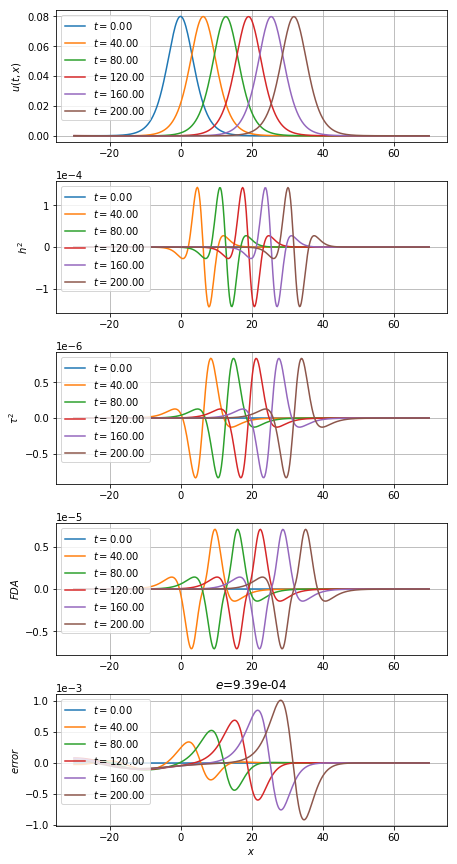

    u = 0.0800[0.0000]
exact = 0.0800[0.0000]
    u = 0.0798[6.5000]
exact = 0.0800[6.5000]
    u = 0.0799[12.7500]
exact = 0.0800[12.7500]
    u = 0.0798[19.2500]
exact = 0.0800[19.2500]
    u = 0.0798[25.5000]
exact = 0.0800[25.5000]
    u = 0.0798[32.0000]
exact = 0.0800[32.0000]


In [6]:
f1, f2, f3 = 0., 3., 0.
L, N = 100., 400
x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
h = x[1] - x[0]
tau = 16.0/2**0*h
print(r"h=%.3e, \tau=%.3e" % (h, tau))
deg_h = 2
k, tend = 0.2, 200
print("k^7=%.2e, k^9=%.2e, k^11=%.2e" % (k**7, k**9, k**11))
exact = lambda x, t: exact1(x, t, k)
sol = solve5(exact(x, 0), tau, h, tend, 5)
draw1(sol, exact, "upper left")
draw1(sol, exact, "upper left", name="./KDV_NUM/111.png")

In [7]:
res = {}
ktaus = [16./2**i for i in range(7)]
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    for ktau in ktaus:
        tau = ktau*h
        sol = solve5(exact(x, 0), tau, h, tend, 5)
        t, u, h2, tau2, fda = sol[-1]
        res[h, ktau] = ("%.1e" % norm(fda, inf), \
            "%.1e" % (norm(u - exact(x, t), inf)/(1 + norm(exact(x, t), inf))))

print("\n")
print(" h & ", " & ".join(str(ktau) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][0] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][1] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % ((h*ktau)**2*k**11) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$h^2 k^7$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % (h**2*k**7) for ktau in ktaus), r"\\ \hline")

4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

 h &  16.0 & 8.0 & 4.0 & 2.0 & 1.0 & 0.5 & 0.25 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline
2.500e-01  &  7.1e-06 & 5.7e-06 & 8.1e-06 & 8.7e-06 & 8.9e-06 & 8.9e-06 & 9.1e-06 \\ \hline
1.250e-01  &  1.8e-06 & 1.4e-06 & 2.0e-06 & 2.2e-06 & 2.2e-06 & 2.2e-06 & 2.3e-06 \\ \hline
6.250e-02  &  4.7e-07 & 3.6e-07 & 5.1e-07 & 5.5e-07 & 5.6e-07 & 5.6e-07 & 5.6e-07 \\ \hline
3.125e-02  &  1.2e-07 & 8.9e-08 & 1.3e-07 & 1.4e-07 & 1.4e-07 & 1.4e-07 & 1.4e-07 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline
2.500e-01  &  9.4e-04 & 3.2e-04 & 1.7e-04 & 1.3e-04 & 1.2e-04 & 1.2e-04 & 1.2e-04 \\ \hline
1.250e-01  &  2.4e-04 & 8.1e-05 & 4.2e-05 

h=2.500e-01, \tau=2.000e+00
k^7=1.64e-03, k^9=2.62e-04, k^11=4.19e-05
5 5 5 5 5     u = 0.3200[0.0000]
exact = 0.3200[0.0000]
    u = 0.3101[8.7500]
exact = 0.3199[9.0000]
    u = 0.3100[17.2500]
exact = 0.3197[18.0000]
    u = 0.3103[26.0000]
exact = 0.3193[27.0000]
    u = 0.3104[34.7500]
exact = 0.3196[35.7500]
    u = 0.3103[43.5000]
exact = 0.3199[44.7500]


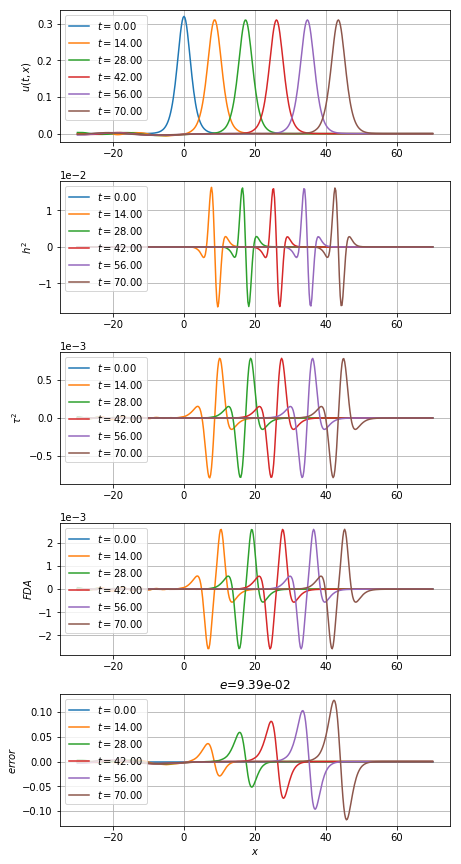

    u = 0.3200[0.0000]
exact = 0.3200[0.0000]
    u = 0.3101[8.7500]
exact = 0.3199[9.0000]
    u = 0.3100[17.2500]
exact = 0.3197[18.0000]
    u = 0.3103[26.0000]
exact = 0.3193[27.0000]
    u = 0.3104[34.7500]
exact = 0.3196[35.7500]
    u = 0.3103[43.5000]
exact = 0.3199[44.7500]


In [8]:
f1, f2, f3 = 0., 3., 0.
L, N = 100., 400
x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
h = x[1] - x[0]
tau = 8.0/2**0*h
print(r"h=%.3e, \tau=%.3e" % (h, tau))
deg_h = 2
k, tend = 0.4, 75
print("k^7=%.2e, k^9=%.2e, k^11=%.2e" % (k**7, k**9, k**11))
exact = lambda x, t: exact1(x, t, k)
sol = solve5(exact(x, 0), tau, h, tend, 5)
draw1(sol, exact, "upper left")
draw1(sol, exact, "upper left", name="./KDV_NUM/112.png")

In [9]:
res = {}
ktaus = [8./2**i for i in range(7)]
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    for ktau in ktaus:
        tau = ktau*h
        sol = solve5(exact(x, 0), tau, h, tend, 5)
        t, u, h2, tau2, fda = sol[-1]
        res[h, ktau] = ("%.1e" % norm(fda, inf), \
            "%.1e" % (norm(u - exact(x, t), inf)/(1 + norm(exact(x, t), inf))))

print("\n")
print(" h & ", " & ".join(str(ktau) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][0] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][1] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % ((h*ktau)**2*k**11) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$h^2 k^7$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % (h**2*k**7) for ktau in ktaus), r"\\ \hline")

5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

 h &  8.0 & 4.0 & 2.0 & 1.0 & 0.5 & 0.25 & 0.125 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline
2.500e-01  &  2.6e-03 & 7.9e-04 & 7.2e-04 & 1.0e-03 & 1.1e-03 & 1.1e-03 & 1.2e-03 \\ \hline
1.250e-01  &  1.2e-03 & 2.3e-04 & 1.8e-04 & 2.6e-04 & 2.8e-04 & 2.8e-04 & 2.9e-04 \\ \hline
6.250e-02  &  3.7e-04 & 5.9e-05 & 4.6e-05 & 6.5e-05 & 7.0e-05 & 7.2e-05 & 7.2e-05 \\ \hline
3.125e-02  &  9.6e-05 & 1.5e-05 & 1.1e-05 & 1.6e-05 & 1.8e-05 & 1.8e-05 & 1.8e-05 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline
2.500e-01  &  9.4e-02 & 3.1e-02 & 1.1e-02 & 5.9e-03 & 4.7e-03 & 4.3e-03 & 4.4e-03 \\ \hline
1.250e-01  &  2.8e-02 & 8.0e-03 & 2.8e-03

h=1.250e-01, \tau=6.250e-02
k^7=2.10e-01, k^9=1.34e-01, k^11=8.59e-02
4 4 4 4 4     u = 1.2800[0.0000]
exact = 1.2800[0.0000]
    u = 1.2757[10.2500]
exact = 1.2799[10.2500]
    u = 1.2759[20.3750]
exact = 1.2797[20.5000]
    u = 1.2773[30.6250]
exact = 1.2793[30.7500]
    u = 1.2761[40.8750]
exact = 1.2787[41.0000]
    u = 1.2755[51.0000]
exact = 1.2780[51.2500]


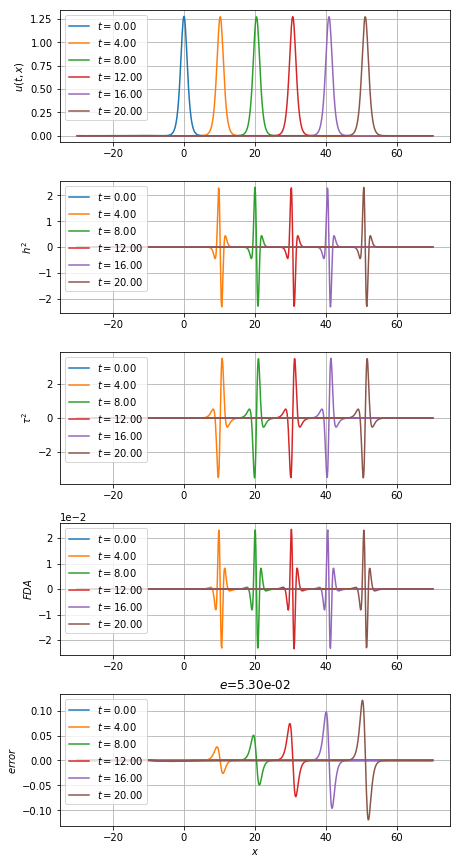

    u = 1.2800[0.0000]
exact = 1.2800[0.0000]
    u = 1.2757[10.2500]
exact = 1.2799[10.2500]
    u = 1.2759[20.3750]
exact = 1.2797[20.5000]
    u = 1.2773[30.6250]
exact = 1.2793[30.7500]
    u = 1.2761[40.8750]
exact = 1.2787[41.0000]
    u = 1.2755[51.0000]
exact = 1.2780[51.2500]


In [10]:
f1, f2, f3 = 0., 3., 0.
L, N = 100., 800
x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
h = x[1] - x[0]
tau = 0.5/2**0*h
print(r"h=%.3e, \tau=%.3e" % (h, tau))
deg_h = 2
k, tend = 0.8, 20
print("k^7=%.2e, k^9=%.2e, k^11=%.2e" % (k**7, k**9, k**11))
exact = lambda x, t: exact1(x, t, k)
sol = solve5(exact(x, 0), tau, h, tend, 5)
draw1(sol, exact, "upper left")
draw1(sol, exact, "upper left", name="./KDV_NUM/113.png")

In [11]:
res = {}
ktaus = [0.5/2**i for i in range(4)]
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    for ktau in ktaus:
        tau = ktau*h
        sol = solve5(exact(x, 0), tau, h, tend, 5)
        t, u, h2, tau2, fda = sol[-1]
        res[h, ktau] = ("%.1e" % norm(fda, inf), \
            "%.1e" % (norm(u - exact(x, t), inf)/(1 + norm(exact(x, t), inf))))

print("\n")
print(" h & ", " & ".join(str(ktau) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][0] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][1] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % ((h*ktau)**2*k**11) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$h^2 k^7$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % (h**2*k**7) for ktau in ktaus), r"\\ \hline")

4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 

 h &  0.5 & 0.25 & 0.125 & 0.0625 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline
1.250e-01  &  2.3e-02 & 3.3e-02 & 3.5e-02 & 3.6e-02 \\ \hline
6.250e-02  &  5.8e-03 & 8.3e-03 & 8.9e-03 & 9.1e-03 \\ \hline
3.125e-02  &  1.5e-03 & 2.1e-03 & 2.3e-03 & 2.3e-03 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline
1.250e-01  &  5.3e-02 & 2.8e-02 & 2.2e-02 & 2.1e-02 \\ \hline
6.250e-02  &  1.3e-02 & 7.1e-03 & 5.6e-03 & 5.2e-03 \\ \hline
3.125e-02  &  3.3e-03 & 1.8e-03 & 1.4e-03 & 1.3e-03 \\ \hline
\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline
1.250e-01  &  3.4e-04 & 8.4e-05 & 2.1e-05 & 5.2e-06 \\ \hline
6.250e-02  &  8.4e-05 & 2.1e-05 & 5.2e-06 & 1.3e-06 \\ \hline
3.125e-02  &  2.1e-05 & 5.2e-06 & 1.3e-06 & 3.3e-07 \\ \hline
\multicolumn{8}{|c|}{$h^2 k^7$} \\ \hline
1.250e-01  &  3.3e-03 & 3.3e

### 12 ###

h=1.250e-01, \tau=2.500e-01
k^7=2.10e-01, k^9=1.34e-01, k^11=8.59e-02
4 4 4 4 4     u = 0.4996[-20.8750]
exact = 0.4996[-20.8750]
    u = 0.4936[-11.8750]
exact = 0.4943[-11.8750]
    u = 0.4322[-2.5000]
exact = 0.4322[-2.5000]
    u = 0.4790[7.7500]
exact = 0.4803[7.7500]
    u = 0.4979[16.7500]
exact = 0.4988[16.8750]
    u = 0.4990[25.7500]
exact = 0.4999[25.8750]


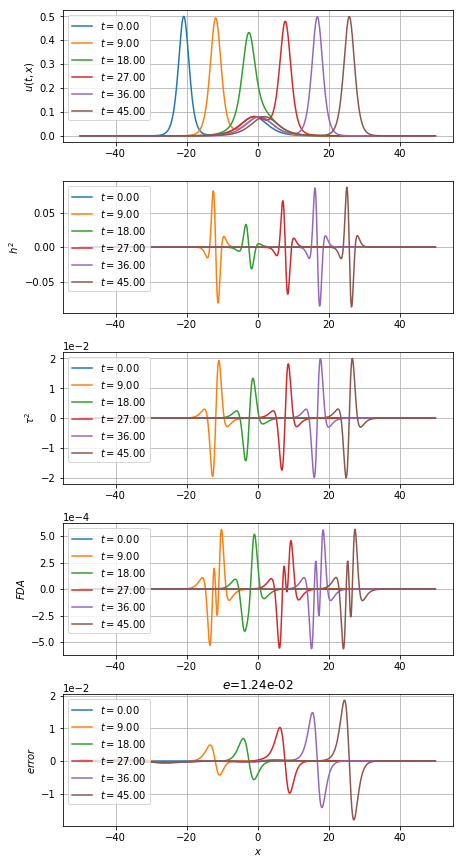

    u = 0.4996[-20.8750]
exact = 0.4996[-20.8750]
    u = 0.4936[-11.8750]
exact = 0.4943[-11.8750]
    u = 0.4322[-2.5000]
exact = 0.4322[-2.5000]
    u = 0.4790[7.7500]
exact = 0.4803[7.7500]
    u = 0.4979[16.7500]
exact = 0.4988[16.8750]
    u = 0.4990[25.7500]
exact = 0.4999[25.8750]


In [12]:
f1, f2, f3 = 0., 3., 0.
L, N = 100., 800
x = linspace(-L*0.5, L*0.5, N+1, dtype=float64)
h = x[1] - x[0]
tau = 2.0/2**0*h
print(r"h=%.3e, \tau=%.3e" % (h, tau))
deg_h = 2
k1, k2, tend = 0.5, 0.2, 45
print("k^7=%.2e, k^9=%.2e, k^11=%.2e" % (k**7, k**9, k**11))
exact = lambda x, t: exact2(x, t - 20, k1, k2)
sol = solve5(exact(x, 0), tau, h, tend, 5)
draw1(sol, exact, "upper left")
draw1(sol, exact, "upper left", name="./KDV_NUM/121.png")

In [13]:
res = {}
ktaus = [2./2**i for i in range(5)]
for N in (800, 1600, 3200):
    x = linspace(-L*0.5, L*0.5, N+1, dtype=float64)
    h = x[1] - x[0]
    for ktau in ktaus:
        tau = ktau*h
        sol = solve5(exact(x, 0), tau, h, tend, 5)
        t, u, h2, tau2, fda = sol[-1]
        res[h, ktau] = ("%.1e" % norm(fda, inf), \
            "%.1e" % (norm(u - exact(x, t), inf)/(1 + norm(exact(x, t), inf))))

print("\n")
print(" h & ", " & ".join(str(ktau) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][0] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (3)^n_{j}|/(1 + |(3)|^n_{j})$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][1] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\tau^2 k_1^{11}$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % ((h*ktau)**2*k1**11) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$h^2 k_1^7$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % (h**2*k**7) for k1tau in ktaus), r"\\ \hline")

4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 3 3 4 4 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 3 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

 h &  2.0 & 1.0 & 0.5 & 0.25 & 0.125 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline
1.250e-01  &  5.6e-04 & 1.0e-03 & 1.3e-03 & 1.3e-03 & 1.4e-03 \\ \hline
6.250e-02  &  1.4e-04 & 2.6e-04 & 3.2e-04 & 3.4e-04 & 3.4e-04 \\ \hline
3.125e-02  &  3.6e-05 & 6.6e-05 & 8.1e-05 & 8.5e-05 & 8.6e-05 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (3)^n_{j}|/(1 + |(3)|^n_{j})$} \\ \hline
1.250e-01  &  1.2e-02 & 5.0e-03 & 3.1e-03 & 2.7e-03 & 2.6e-03 \\ \hline
6.250e-02  &  3.1e-03 & 1.2e-03 & 7.8e-04 & 6.7e-04 & 6.4e-04 \\ \hline
3.125e-02  &  7.8e-04 & 3.1e-04 & 2.0e-04 & 1.7e-04 & 1.6e-04 \\ \hline
\multicolumn{8}{|c|}{$\tau^2 k_1^{11}$} \\ \hline
1.250e-01  &  3.1e-05 & 7.6e-06 & 1.9e-06 & 4.8e-07 & 1.2e-07 \\ \hline
6.250e-02  &  7.6e-06 & 1.9e-06 & 4.8e-07 & 1.2e-07 & 3.0e-08 \\ \hline
3.125e-02  &  1.9

### 21 ###

h=2.500e-01, \tau=4.000e+00
k^7=1.28e-05, k^9=5.12e-07, k^11=2.05e-08
4 4 4 4 4     u = 0.0800[0.0000]
exact = 0.0800[0.0000]
    u = 0.0798[6.5000]
exact = 0.0800[6.5000]
    u = 0.0799[12.7500]
exact = 0.0800[12.7500]
    u = 0.0798[19.2500]
exact = 0.0800[19.2500]
    u = 0.0799[25.5000]
exact = 0.0800[25.5000]
    u = 0.0798[32.0000]
exact = 0.0800[32.0000]


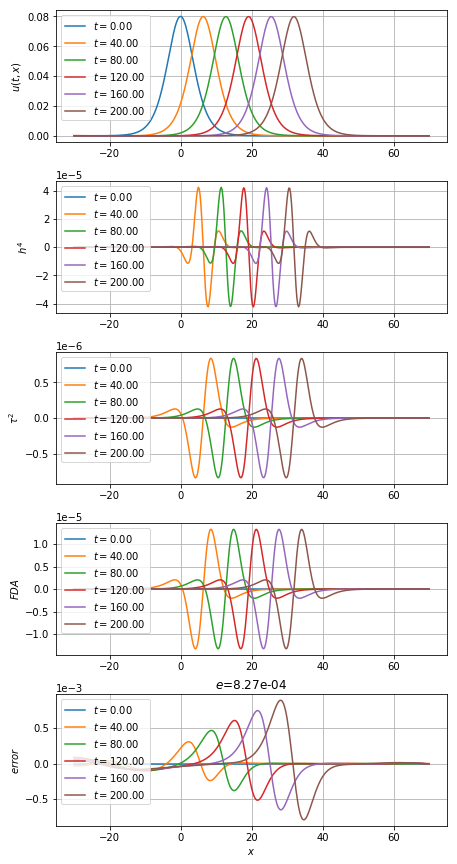

    u = 0.0800[0.0000]
exact = 0.0800[0.0000]
    u = 0.0798[6.5000]
exact = 0.0800[6.5000]
    u = 0.0799[12.7500]
exact = 0.0800[12.7500]
    u = 0.0798[19.2500]
exact = 0.0800[19.2500]
    u = 0.0799[25.5000]
exact = 0.0800[25.5000]
    u = 0.0798[32.0000]
exact = 0.0800[32.0000]


In [14]:
f1, f2, f3 = 0., 3., 0.
L, N = 100., 400
x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
h = x[1] - x[0]
tau = 16.0/2**0*h
print(r"h=%.3e, \tau=%.3e" % (h, tau))
deg_h = 4
k, tend = 0.2, 200
print("k^7=%.2e, k^9=%.2e, k^11=%.2e" % (k**7, k**9, k**11))
exact = lambda x, t: exact1(x, t, k)
sol = solve7(exact(x, 0), tau, h, tend, 5)
draw1(sol, exact, "upper left")
draw1(sol, exact, "upper left", name="./KDV_NUM/211.png")

In [15]:
res = {}
ktaus = [16./2**i for i in range(3)]
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    for ktau in ktaus:
        tau = ktau*h
        sol = solve7(exact(x, 0), tau, h, tend, 5)
        t, u, h2, tau2, fda = sol[-1]
        res[h, ktau] = ("%.1e" % norm(fda, inf), \
            "%.1e" % (norm(u - exact(x, t), inf)/(1 + norm(exact(x, t), inf))))

print("\n")
print(" h & ", " & ".join(str(ktau) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][0] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][1] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % ((h*ktau)**2*k**11) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$h^2 k^9$} \\ \hline")
for N in (400, 800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % (h**2*k**9) for ktau in ktaus), r"\\ \hline")

4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 

 h &  16.0 & 8.0 & 4.0 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline
2.500e-01  &  1.3e-05 & 3.4e-06 & 8.0e-07 \\ \hline
1.250e-01  &  3.5e-06 & 8.8e-07 & 2.2e-07 \\ \hline
6.250e-02  &  8.9e-07 & 2.2e-07 & 5.5e-08 \\ \hline
3.125e-02  &  2.2e-07 & 5.6e-08 & 1.4e-08 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline
2.500e-01  &  8.3e-04 & 2.1e-04 & 5.2e-05 \\ \hline
1.250e-01  &  2.1e-04 & 5.2e-05 & 1.3e-05 \\ \hline
6.250e-02  &  5.2e-05 & 1.3e-05 & 3.1e-06 \\ \hline
3.125e-02  &  1.3e-05 & 3.2e-06 & 7.5e-07 \\ \hline
\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline
2.500e-01  &  3.3e-07 & 8.2e-08 & 2.0e-08 \\ \hline
1.250e-01  &  8.2e-08 & 2.0e-08 & 5.1e-09 \\ \hline
6.250e-02  &  2.0e-08 & 5.1e-09 & 1.3e-09 \\ \hline
3.125e-02  &  5.1e-09 & 1.3e-09 & 3.2e-10 \\ \hline
\multicolumn{8}

h=1.250e-01, \tau=5.000e-01
k^7=1.64e-03, k^9=2.62e-04, k^11=4.19e-05
4 4 4 4 4     u = 0.3200[0.0000]
exact = 0.3200[0.0000]
    u = 0.3193[9.6250]
exact = 0.3200[9.6250]
    u = 0.3194[19.1250]
exact = 0.3199[19.2500]
    u = 0.3194[28.7500]
exact = 0.3199[28.7500]
    u = 0.3193[38.3750]
exact = 0.3200[38.3750]
    u = 0.3194[47.8750]
exact = 0.3200[48.0000]


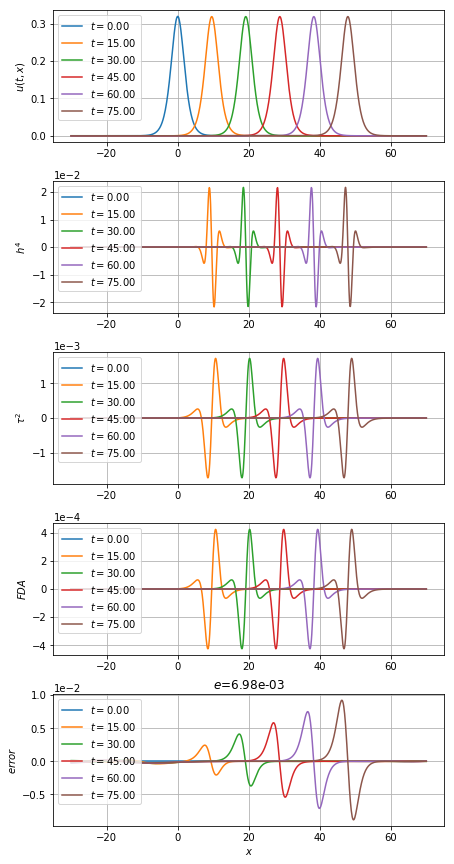

    u = 0.3200[0.0000]
exact = 0.3200[0.0000]
    u = 0.3193[9.6250]
exact = 0.3200[9.6250]
    u = 0.3194[19.1250]
exact = 0.3199[19.2500]
    u = 0.3194[28.7500]
exact = 0.3199[28.7500]
    u = 0.3193[38.3750]
exact = 0.3200[38.3750]
    u = 0.3194[47.8750]
exact = 0.3200[48.0000]


In [16]:
f1, f2, f3 = 0., 3., 0.
L, N = 100., 800
x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
h = x[1] - x[0]
tau = 4.0/2**0*h
print(r"h=%.3e, \tau=%.3e" % (h, tau))
deg_h = 4
k, tend = 0.4, 75
print("k^7=%.2e, k^9=%.2e, k^11=%.2e" % (k**7, k**9, k**11))
exact = lambda x, t: exact1(x, t, k)
sol = solve7(exact(x, 0), tau, h, tend, 5)
draw1(sol, exact, "upper left")
draw1(sol, exact, "upper left", name="./KDV_NUM/212.png")

In [17]:
res = {}
ktaus = [4./2**i for i in range(3)]
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    for ktau in ktaus:
        tau = ktau*h
        sol = solve7(exact(x, 0), tau, h, tend, 5)
        t, u, h2, tau2, fda = sol[-1]
        res[h, ktau] = ("%.1e" % norm(fda, inf), \
            "%.1e" % (norm(u - exact(x, t), inf)/(1 + norm(exact(x, t), inf))))

print("\n")
print(" h & ", " & ".join(str(ktau) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][0] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][1] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % ((h*ktau)**2*k**11) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$h^2 k^9$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % (h**2*k**9) for ktau in ktaus), r"\\ \hline")

4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 

 h &  4.0 & 2.0 & 1.0 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline
1.250e-01  &  4.3e-04 & 1.1e-04 & 2.5e-05 \\ \hline
6.250e-02  &  1.1e-04 & 2.8e-05 & 6.9e-06 \\ \hline
3.125e-02  &  2.8e-05 & 7.1e-06 & 1.8e-06 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline
1.250e-01  &  7.0e-03 & 1.8e-03 & 4.3e-04 \\ \hline
6.250e-02  &  1.8e-03 & 4.4e-04 & 1.1e-04 \\ \hline
3.125e-02  &  4.4e-04 & 1.1e-04 & 2.7e-05 \\ \hline
\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline
1.250e-01  &  1.0e-05 & 2.6e-06 & 6.6e-07 \\ \hline
6.250e-02  &  2.6e-06 & 6.6e-07 & 1.6e-07 \\ \hline
3.125e-02  &  6.6e-07 & 1.6e-07 & 4.1e-08 \\ \hline
\multicolumn{8}{|c|}{$h^2 k^9$} \\ \hline
1.250e-01  &  4.1e-06 & 4.1e-06 & 4.1e-06 \\ \hline
6.250e-02  &  1.0e-06 & 1.0e-06 & 1.0e-06 \\ \hline
3.125e-02  &  2.6e-07 & 2.6e-07 & 2.6e-07 \\ \hline


h=1.250e-01, \tau=1.250e-01
k^7=2.10e-01, k^9=1.34e-01, k^11=8.59e-02
5 5 5 5 5     u = 1.2800[0.0000]
exact = 1.2800[0.0000]
    u = 1.2699[10.1250]
exact = 1.2799[10.2500]
    u = 1.2688[20.3750]
exact = 1.2797[20.5000]
    u = 1.2705[30.5000]
exact = 1.2793[30.7500]
    u = 1.2699[40.6250]
exact = 1.2787[41.0000]
    u = 1.2693[50.8750]
exact = 1.2780[51.2500]


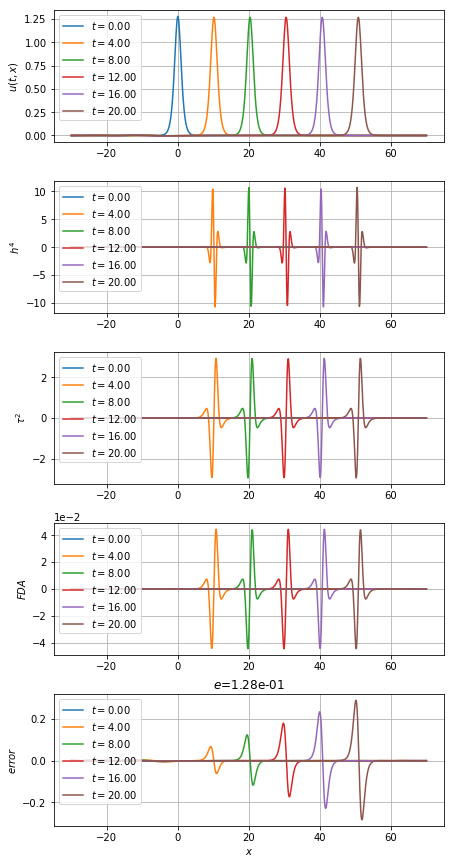

    u = 1.2800[0.0000]
exact = 1.2800[0.0000]
    u = 1.2699[10.1250]
exact = 1.2799[10.2500]
    u = 1.2688[20.3750]
exact = 1.2797[20.5000]
    u = 1.2705[30.5000]
exact = 1.2793[30.7500]
    u = 1.2699[40.6250]
exact = 1.2787[41.0000]
    u = 1.2693[50.8750]
exact = 1.2780[51.2500]


In [18]:
f1, f2, f3 = 0., 3., 0.
L, N = 100., 800
x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
h = x[1] - x[0]
tau = 1.0/2**0*h
print(r"h=%.3e, \tau=%.3e" % (h, tau))
deg_h = 4
k, tend = 0.8, 20
print("k^7=%.2e, k^9=%.2e, k^11=%.2e" % (k**7, k**9, k**11))
exact = lambda x, t: exact1(x, t, k)
sol = solve7(exact(x, 0), tau, h, tend, 5)
draw1(sol, exact, "upper left")
draw1(sol, exact, "upper left", name="./KDV_NUM/213.png")

In [19]:
res = {}
ktaus = [1.0/2**i for i in range(2)]
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    for ktau in ktaus:
        tau = ktau*h
        sol = solve7(exact(x, 0), tau, h, tend, 5)
        t, u, h2, tau2, fda = sol[-1]
        res[h, ktau] = ("%.1e" % norm(fda, inf), \
            "%.1e" % (norm(u - exact(x, t), inf)/(1 + norm(exact(x, t), inf))))

print("\n")
print(" h & ", " & ".join(str(ktau) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][0] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][1] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % ((h*ktau)**2*k**11) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$h^2 k^9$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % (h**2*k**9) for ktau in ktaus), r"\\ \hline")

5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 

 h &  1.0 & 0.5 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline
1.250e-01  &  4.4e-02 & 1.2e-02 \\ \hline
6.250e-02  &  1.4e-02 & 3.5e-03 \\ \hline
3.125e-02  &  3.6e-03 & 9.0e-04 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (2)^n_{j}|/(1 + |(2)|^n_{j})$} \\ \hline
1.250e-01  &  1.3e-01 & 3.3e-02 \\ \hline
6.250e-02  &  3.3e-02 & 8.3e-03 \\ \hline
3.125e-02  &  8.3e-03 & 2.1e-03 \\ \hline
\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline
1.250e-01  &  1.3e-03 & 3.4e-04 \\ \hline
6.250e-02  &  3.4e-04 & 8.4e-05 \\ \hline
3.125e-02  &  8.4e-05 & 2.1e-05 \\ \hline
\multicolumn{8}{|c|}{$h^2 k^9$} \\ \hline
1.250e-01  &  2.1e-03 & 2.1e-03 \\ \hline
6.250e-02  &  5.2e-04 & 5.2e-04 \\ \hline
3.125e-02  &  1.3e-04 & 1.3e-04 \\ \hline


### 22 ###

h=1.250e-01, \tau=2.500e-01
k^7=2.10e-01, k^9=1.34e-01, k^11=8.59e-02
4 4 4 4 4     u = 0.4996[-20.8750]
exact = 0.4996[-20.8750]
    u = 0.4937[-11.8750]
exact = 0.4943[-11.8750]
    u = 0.4322[-2.5000]
exact = 0.4322[-2.5000]
    u = 0.4793[7.7500]
exact = 0.4803[7.7500]
    u = 0.4979[16.7500]
exact = 0.4988[16.8750]
    u = 0.4990[25.7500]
exact = 0.4999[25.8750]


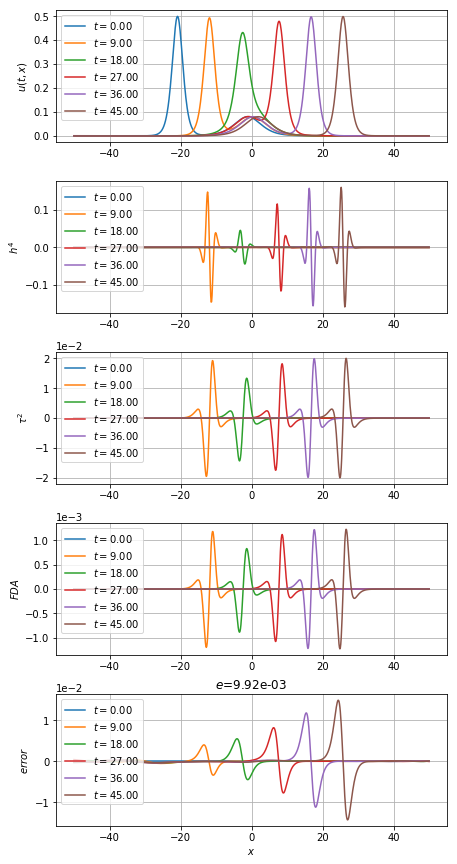

    u = 0.4996[-20.8750]
exact = 0.4996[-20.8750]
    u = 0.4937[-11.8750]
exact = 0.4943[-11.8750]
    u = 0.4322[-2.5000]
exact = 0.4322[-2.5000]
    u = 0.4793[7.7500]
exact = 0.4803[7.7500]
    u = 0.4979[16.7500]
exact = 0.4988[16.8750]
    u = 0.4990[25.7500]
exact = 0.4999[25.8750]


In [20]:
f1, f2, f3 = 0., 3., 0.
L, N = 100., 800
x = linspace(-L*0.5, L*0.5, N+1, dtype=float64)
h = x[1] - x[0]
tau = 2.0/2**0*h
print(r"h=%.3e, \tau=%.3e" % (h, tau))
deg_h = 4
k1, k2, tend = 0.5, 0.2, 45
print("k^7=%.2e, k^9=%.2e, k^11=%.2e" % (k**7, k**9, k**11))
exact = lambda x, t: exact2(x, t-20, k1, k2)
sol = solve7(exact(x, 0), tau, h, tend, 5)
draw1(sol, exact, "upper left")
draw1(sol, exact, "upper left", name="./KDV_NUM/221.png")

In [21]:
res = {}
ktaus = [2./2**i for i in range(2)]
for N in (800, 1600, 3200):
    x = linspace(-L*0.5, L*0.5, N+1, dtype=float64)
    h = x[1] - x[0]
    for ktau in ktaus:
        tau = ktau*h
        sol = solve7(exact(x, 0), tau, h, tend, 5)
        t, u, h2, tau2, fda = sol[-1]
        res[h, ktau] = ("%.1e" % norm(fda, inf), \
            "%.1e" % (norm(u - exact(x, t), inf)/(1 + norm(exact(x, t), inf))))

print("\n")
print(" h & ", " & ".join(str(ktau) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][0] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (3)^n_{j}|/(1 + |(3)|^n_{j})$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join(res[h, ktau][1] for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % ((h*ktau)**2*k**11) for ktau in ktaus), r"\\ \hline")
print(r"\multicolumn{8}{|c|}{$h^2 k^9$} \\ \hline")
for N in (800, 1600, 3200):
    x = linspace(-L*0.3, L*0.7, N+1, dtype=float64)
    h = x[1] - x[0]
    print("%.3e" % h, " & ", " & ".join("%.1e" % (h**2*k**9) for ktau in ktaus), r"\\ \hline")

4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 

 h &  2.0 & 1.0 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |FDA|^n_{j}$} \\ \hline
1.250e-01  &  1.2e-03 & 3.0e-04 \\ \hline
6.250e-02  &  3.3e-04 & 8.1e-05 \\ \hline
3.125e-02  &  8.3e-05 & 2.1e-05 \\ \hline
\multicolumn{8}{|c|}{$\max\limits_{n, j} |u^n_{j} - (3)^n_{j}|/(1 + |(3)|^n_{j})$} \\ \hline
1.250e-01  &  9.9e-03 & 2.5e-03 \\ \hline
6.250e-02  &  2.5e-03 & 6.2e-04 \\ \hline
3.125e-02  &  6.2e-04 & 1.6e-04 \\ \hline
\multicolumn{8}{|c|}{$\tau^2 k^{11}$} \\ \hline
1.250e-01  &  5.4e-03 & 1.3e-03 \\ \hline
6.250e-02  &  1.3e-03 & 3.4e-04 \\ \hline
3.125e-02  &  3.4e-04 & 8.4e-05 \\ \hline
\multicolumn{8}{|c|}{$h^2 k^9$} \\ \hline
1.250e-01  &  2.1e-03 & 2.1e-03 \\ \hline
6.250e-02  &  5.2e-04 & 5.2e-04 \\ \hline
3.125e-02  &  1.3e-04 & 1.3e-04 \\ \hline
